<a href="https://colab.research.google.com/github/NicKostii/UniProjects/blob/main/IDSS/Lab_work_2_(IDSS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лобораторна робота №2   
## Реалiзацiя багатошарового персептрона для класифiкацiї зображень MNIST в Python з нуля засобами Numpy  
Тюкалов Ніколай  
КА-13  
Варіант №3 - Kuzushiji MNIST


## Хід роботи  

1. Завантажити простий набiр зображень згiдно з варiантом.
2. Виконати пiдготовку даних для навчання - за необхiдностi, залежно вiд
вхiдного набору. Наприклад, нормалiзувати данi тощо.

3. За необхiдностi розбити данi на навчальну i перевiрочну множини у спiв-
вiдношеннi 80%: 20%. Звернути увагу, що завантаженi данi вже можуть бути розбитi на навчальну i перевiрочну множини.

4. Побудувати базову мережу прямого розповсюдження сигналу з єдиним скритим шаром i output шаром softmax. Для створення моделi реалiзувати власний клас, який наслiдує клас object. Ваги iнiцiалiзувати невеликими випадковими значеннями, якi нормально розподiленi з нульовим середнiм та малою дисперсiєю.

5. Реалiзувати алгоритм зворотного розповсюдження помилки (back propagation).

6. Функцiєю втрат задати перехресну ентропiю.

7. Налаштувати ваги побудованої мережi реалiзованим алгоритмом back
propagation.

8. Побудувати кiлька альтернативних мереж MLP з кiлькома скритими
шарами ReLU або tanh. Налаштувати їх ваги реалiзованим алгоритмом
back propagation.

9. Для кожної моделi побудувати:

  • графiки змiни значень функцiї втрат на тренувальнiй i перевiро-
чнiй множинах по мiрi навчання моделi, тобто залежно вiд кiлькостi епох,

  • графiки змiни показника accuracy на тренувальнiй i перевiрочнiй
множинах по мiрi навчання моделi.

10. Пiдiбрати значення гiперпараметра швидкостi навчання.

11. Обрати для нейронiв скритих шарiв рiзнi функцiї активацiї: LeakyReLU,
Parametric LeakyReLU, ELU. Спробувати з’ясувати чи впливає вибiр функцiї активацiї на:  

  • час навчання мережi,  

  • якiсть роботи мережi (фiнальне значення accuracy) на перевiрочнiй множинi,

  • час надання прогнозу мережею.  

12. Вiдобразити кiлька зображень, невiрно класифiкованих моделлю.

13. Дати вiдповiдi на контрольнi питання (усно).

В роботі використовуєтсья наступний датасет: "KMNIST Dataset" (created by CODH), adapted from "Kuzushiji Dataset" (created by NIJL and others), doi:10.20676/00000341

## Імпорти

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
import random

## Датасет

In [ ]:
X_train = np.load('/content/drive/MyDrive/Datasets/KMNIST/kmnist-train-imgs.npz')['arr_0']
X_test = np.load('/content/drive/MyDrive/Datasets/KMNIST/kmnist-test-imgs.npz')['arr_0']
y_train = np.load('/content/drive/MyDrive/Datasets/KMNIST/kmnist-train-labels.npz')['arr_0']
y_test = np.load('/content/drive/MyDrive/Datasets/KMNIST/kmnist-test-labels.npz')['arr_0']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

In [ ]:
def show_images_by_class(X_test, y_test, num_images_per_class=10):
    num_classes = len(np.unique(y_test))

    fig, axes = plt.subplots(nrows=num_classes, ncols=num_images_per_class, figsize=(12, 12))

    for class_idx in range(num_classes):
        class_indices = np.where(y_test == class_idx)[0]
        sample_indices = np.random.choice(class_indices, size=num_images_per_class, replace=False)

        for i, idx in enumerate(sample_indices):
            axes[class_idx, i].imshow(X_test[idx], cmap='gray')
            axes[class_idx, i].axis('off')
            axes[class_idx, i].set_title(f"Class: {class_idx}")

    plt.tight_layout()
    plt.show()

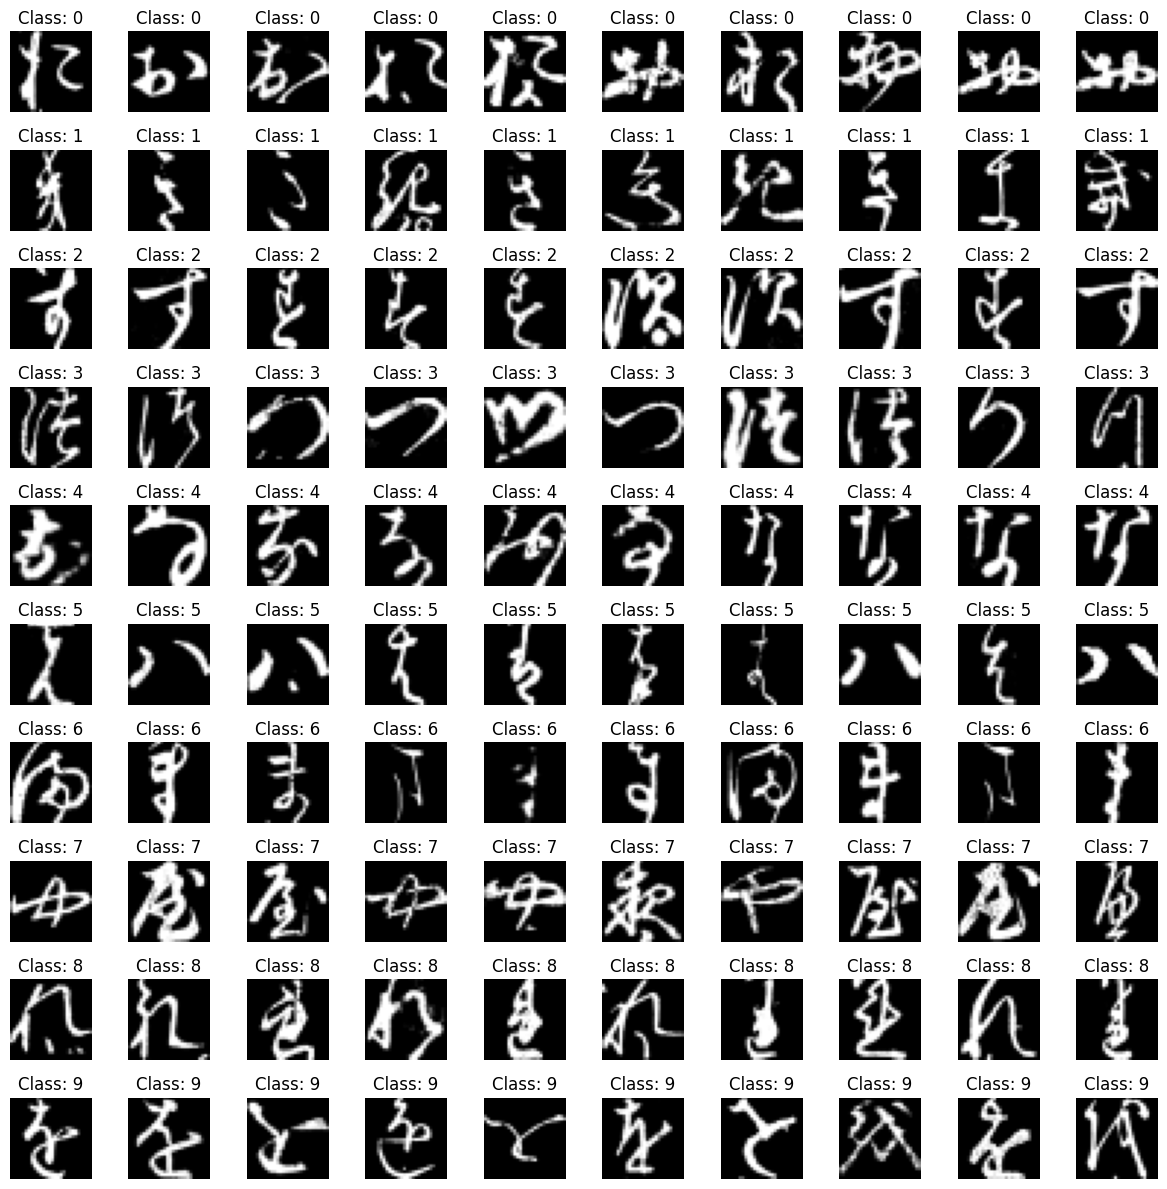

In [ ]:
show_images_by_class(X_test, y_test,)

Датасет вигялдає дуже складним, тому я б не очикував неймовірної точності. Я підозрюю, що навіть повноцінна бібліотека буде мати складнощі.

In [ ]:
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test = X_test.reshape(-1, 28*28) / 255.0

In [ ]:
print(X_train.shape)
print(X_test.shape)

(8000, 784)
(2000, 784)


In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

Отже в датасеті мав набір зображень 28х28 пікселей, є 60к прикладів в тренувальному наборі та також 10к в тестовому. Всього в датасеті маємо 10 класів і вони равномірно розподілен, збалансовані.


Датасет не потребує якоїсь додаткової обробки: зображення представлені в ЧБ, тобто кольоровий канал вже й так один, розмір зображення напевно мінімальний припустимий, зменшувати додатково погано вплине на навчання та здібність впізнавати зображення. Саме розбиття на тренувальну та тестову частину зробили вже за нас.
В процесі роботи варто буде One-Hot encode наши класи.

Було використано лише частину датасету.

## Побудова MLP

In [ ]:
import numpy as np

def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-10
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    epsilon = 1e-10
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return ((1 - y_true) / (1 - y_pred + epsilon) - y_true / (y_pred + epsilon)) / np.size(y_true)

class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))


class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class LeakyReLU(Activation):
    def __init__(self, alpha=0.01):
        def leaky_relu(x):
            return np.maximum(alpha * x, x)

        def leaky_relu_prime(x):
            dx = np.ones_like(x)
            dx[x < 0] = alpha
            return dx

        super().__init__(leaky_relu, leaky_relu_prime)

class ParametricLeakyReLU(Activation):
    def __init__(self, alpha=0.01):
        self.alpha = alpha

        def parametric_leaky_relu(x):
            return np.maximum(self.alpha * x, x)

        def parametric_leaky_relu_prime(x):
            dx = np.ones_like(x)
            dx[x < 0] = self.alpha
            return dx

        super().__init__(parametric_leaky_relu, parametric_leaky_relu_prime)

class ELU(Activation):
    def __init__(self, alpha=1.0):
        self.alpha = alpha

        def elu(x):
            return np.where(x > 0, x, self.alpha * (np.exp(x) - 1))

        def elu_prime(x):
            return np.where(x > 0, 1, self.alpha * np.exp(x))

        super().__init__(elu, elu_prime)

class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.where(x >= 0, x, 0)

        def relu_prime(x):
            return np.where(x > 0, 1, 0)

        super().__init__(relu, relu_prime)

class Softmax(Layer):

    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output

    # def forward(self, input):
    #     exp = input - np.exp(np.max(input, axis=1, keepdims=True))
    #     self.output = exp / np.sum(exp, axis=1, keepdims=True)
    #     return self.output

    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

class MLP(object):
    def __init__(self, network, epochs = 1000, learning_rate = 0.01, verbose = True):
      self.network = network
      self.epochs = epochs
      self.learning_rate = learning_rate
      self.verbose = verbose

    def predict(self, input):
      output = input
      network = self.network
      for layer in network:
          output = layer.forward(output)
      return output

    def train(self,x_train, y_train, x_test, y_test):

      self.train_loss = []
      self.train_accuracy = []
      self.test_loss = []
      self.test_accuracy = []

      for e in range(self.epochs):
          error = 0
          counter = 0
          for x, y in zip(x_train, y_train):
              # forward
              output = self.predict(x)

              # error
              error += binary_cross_entropy(y, output)

              if np.argmax(output) == np.argmax(y):
                counter = counter + 1

              # backward
              grad = binary_cross_entropy_prime(y, output)
              for layer in reversed(self.network):
                  grad = layer.backward(grad, self.learning_rate)

          self.train_accuracy.append(counter / len(x_train))
          self.train_loss.append(error / len(x_train))

          if self.verbose > 0 and e% self.verbose == 0:
              print(f"{e + 1}/{self.epochs}, train error={error / len(x_train)}, train accuracy = {counter / len(x_train)}")

          error = 0
          counter = 0

          for x, y in zip(x_test, y_test):
              output = self.predict(x)
              error += binary_cross_entropy(y, output)

              if np.argmax(output) == np.argmax(y):
                counter = counter + 1

          if self.verbose > 0 and e% self.verbose == 0:
              print(f"{e + 1}/{self.epochs}, test error={error / len(x_test)}, test accuracy = {counter / len(x_test)}")

          self.test_accuracy.append(counter / len(x_test))
          self.test_loss.append(error / len(x_test))

In [ ]:
def one_hot(y, num_classes=None):
    if num_classes is None:
        num_classes = np.max(y) + 1
    categorical = np.zeros((len(y), num_classes))
    for i, val in enumerate(y):
        categorical[i, val] = 1
    return categorical

## Використання MLP

### Побудова моделі

In [ ]:
y_train = one_hot(y_train, len(np.unique(y_train)))
y_test = one_hot(y_test, len(np.unique(y_test)))

In [ ]:
y_train = y_train.reshape(y_train.shape[0], 10,1)
y_test = y_test.reshape(y_test.shape[0], 10,1)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28 * 28,1)
X_test = X_test.reshape(X_test.shape[0], 28 * 28,1)

In [ ]:
network = [
    Dense(28 * 28, 100),
    Tanh(),
    Dense(100, 10),
    Softmax()
]

# train
model = MLP(network, epochs=100, learning_rate=0.01, verbose = 1)
model.train( X_train, y_train, X_test, y_test)

1/100, train error=1.2572794495733968, train accuracy = 0.181375
1/100, test error=0.886727877353533, test accuracy = 0.2785
2/100, train error=0.7031930759104468, train accuracy = 0.34325
2/100, test error=0.650025423379717, test accuracy = 0.3645
3/100, train error=0.5084800510458505, train accuracy = 0.451625
3/100, test error=0.5383868337272293, test accuracy = 0.4205
4/100, train error=0.4087305495007959, train accuracy = 0.508875
4/100, test error=0.4752224817186283, test accuracy = 0.455
5/100, train error=0.3460546473985966, train accuracy = 0.555625
5/100, test error=0.4336838319386286, test accuracy = 0.4765
6/100, train error=0.30275802766132376, train accuracy = 0.589125
6/100, test error=0.4030102731504444, test accuracy = 0.4935
7/100, train error=0.27059375174636163, train accuracy = 0.61325
7/100, test error=0.3787596487669749, test accuracy = 0.5075
8/100, train error=0.24583646340524146, train accuracy = 0.636625
8/100, test error=0.3589701139204494, test accuracy = 0

In [ ]:
print(f"Train accuracy: {model.train_accuracy[-1]}, Train loss: {model.train_loss[-1]} \nTest accuracy: {model.test_accuracy[-1]}, Test loss: {model.test_loss[-1]}")

Train accuracy: 0.9315, Train loss: 0.04825161074663706 
Test accuracy: 0.658, Test loss: 0.23567921531922653


Отже отримали не дуже гарну точність. Насправді я робив прогон з повним датасетом  (60к тест. прикладів) замість цієї частини (8к тест. прикладів) і точність сягала 75% - 80%, що вже непогано, відверто кажучи, АЛЕ це зайняло на мої  машині злочинно багато часу (годину) і я прям зовсім не збераюся витрачати по годині на генерування кожної моделі.

### Графіки

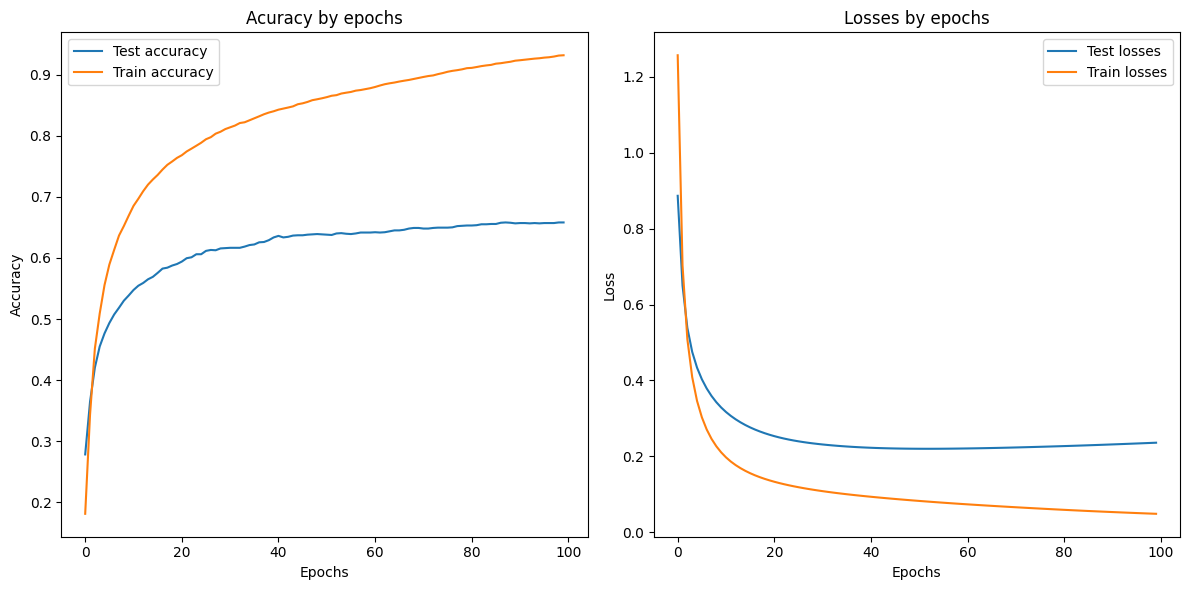

In [ ]:
# Створення нового зображення та осей з двома підграфіками
fig, axs = plt.subplots(1,2, figsize=(12, 6))

# Перший підграфік
axs[0].plot(model.test_accuracy, label='Test accuracy')
axs[0].plot(model.train_accuracy, label='Train accuracy')
axs[0].set_title('Acuracy by epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Другий підграфік
axs[1].plot(model.test_loss, label='Test losses')
axs[1].plot(model.train_loss, label='Train losses')
axs[1].set_title('Losses by epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Відображення зображення з усіма підграфіками
plt.tight_layout()
#plt.subplots_adjust(left=0.1, right=0.9)
plt.show()

## Порівняння з результатами TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

model = models.Sequential([
    layers.Dense(100, activation='relu', input_shape=(28*28,)),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

t_x_test = np.load('/content/drive/MyDrive/Datasets/KMNIST/kmnist-test-imgs.npz')['arr_0']
t_y_test = np.load('/content/drive/MyDrive/Datasets/KMNIST/kmnist-test-labels.npz')['arr_0']

t_x_test =t_x_test.reshape(len(t_x_test), 28*28)

t_X_train, t_X_test, t_y_train, t_y_test = train_test_split(t_x_test, t_y_test, test_size=0.2, random_state=42)

# Навчання моделі
history = model.fit(t_X_train, t_y_train, epochs=100, validation_data=(t_X_test, t_y_test))

# Оцінка моделі на тестових даних
test_loss, test_acc = model.evaluate(t_X_test, t_y_test)
print('Test accuracy:', test_acc)

Epoch 1/100
250/250 [==============================] - 2s 4ms/step - loss: 16.9323 - accuracy: 0.4588 - val_loss: 2.6291 - val_accuracy: 0.3795
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 1.8931 - accuracy: 0.4565 - val_loss: 2.1164 - val_accuracy: 0.4505
Epoch 3/100
250/250 [==============================] - 1s 4ms/step - loss: 1.4925 - accuracy: 0.5244 - val_loss: 1.9888 - val_accuracy: 0.5150
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 1.2347 - accuracy: 0.5995 - val_loss: 1.9143 - val_accuracy: 0.5590
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 1.1310 - accuracy: 0.6379 - val_loss: 1.8362 - val_accuracy: 0.5900
Epoch 6/100
250/250 [==============================] - 1s 5ms/step - loss: 1.0771 - accuracy: 0.6661 - val_loss: 1.7615 - val_accuracy: 0.6070
Epoch 7/100
250/250 [==============================] - 1s 5ms/step - loss: 0.9834 - accuracy: 0.6873 - val_loss: 1.6453 - val_accuracy: 0.622

Отже можна побачити що ~40 епохи, TF досяг 80% точності і, фактично, досяг потолка. В якомусь сенсі, очикувано, що професійна бібліотека показал себе значно краще, але навіть занадто краще трохи.

## Пара альернативних моделелй

### Перша

Побудуємо ще одну модель з активатором ReLU замість Tanh.

In [ ]:
network_2 = [
    Dense(28 * 28, 100),
    ReLU(),
    Dense(100, 10),
    Softmax()
]

# train
model_2 = MLP(network_2, epochs=100, learning_rate=0.01, verbose = 10)
model_2.train( X_train, y_train, X_test, y_test)

1/100, train error=3.2592014283752317, train accuracy = 0.190125
1/100, test error=2.790001898960557, test accuracy = 0.293
11/100, train error=0.7346317465819728, train accuracy = 0.68725
11/100, test error=0.9251641114934388, test accuracy = 0.61
21/100, train error=0.28466491617011574, train accuracy = 0.787375
21/100, test error=0.4861257594269426, test accuracy = 0.657
31/100, train error=0.1607547141641179, train accuracy = 0.8415
31/100, test error=0.3722443211965562, test accuracy = 0.681
41/100, train error=0.10898846984346076, train accuracy = 0.8715
41/100, test error=0.32256377965385186, test accuracy = 0.688
51/100, train error=0.08704129809916512, train accuracy = 0.89625
51/100, test error=0.3007205036439589, test accuracy = 0.695
61/100, train error=0.07341695644723058, train accuracy = 0.914875
61/100, test error=0.29507104135810747, test accuracy = 0.7025
71/100, train error=0.06299578300810137, train accuracy = 0.9275
71/100, test error=0.29705148763544365, test accu

Можна побачити, що активатор ReLU спорався краще, значно краще (65% -> 72% accuracy).   
Побудуємо графіки:

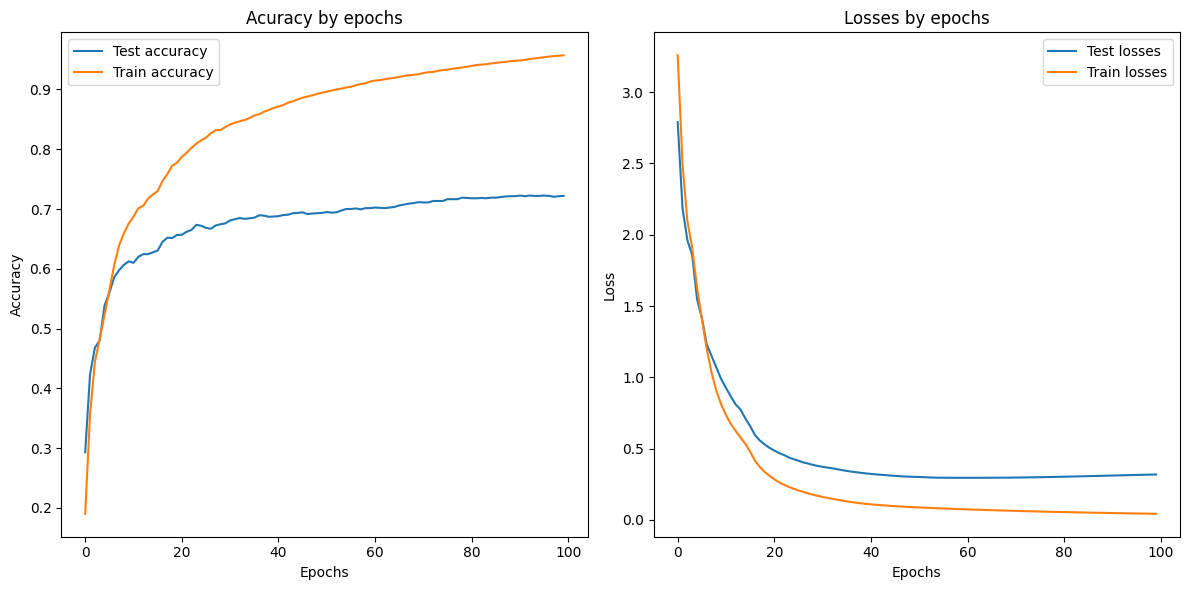

In [ ]:
# Створення нового зображення та осей з двома підграфіками
fig, axs = plt.subplots(1,2, figsize=(12, 6))

# Перший підграфік
axs[0].plot(model_2.test_accuracy, label='Test accuracy')
axs[0].plot(model_2.train_accuracy, label='Train accuracy')
axs[0].set_title('Acuracy by epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Другий підграфік
axs[1].plot(model_2.test_loss, label='Test losses')
axs[1].plot(model_2.train_loss, label='Train losses')
axs[1].set_title('Losses by epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Відображення зображення з усіма підграфіками
plt.tight_layout()
#plt.subplots_adjust(left=0.1, right=0.9)
plt.show()

### Друга

Спробуємо побудувати мережу з трьома скритими шарами.

In [ ]:
network_3 = [
    Dense(28 * 28, 100),
    Tanh(),
    Dense(100, 100),
    Tanh(),
    Dense(100, 100),
   Tanh(),
    Dense(100, 10),
    Softmax()
]

# train
model_3 = MLP(network_3, epochs=100, learning_rate=0.01, verbose = 9)
model_3.train( X_train, y_train, X_test, y_test)

1/100, train error=1.2682256570266313, train accuracy = 0.17225
1/100, test error=0.9774690414584718, test accuracy = 0.2025
10/100, train error=0.20419046512083075, train accuracy = 0.569625
10/100, test error=0.29753309043416254, test accuracy = 0.4115
19/100, train error=0.13296061484643923, train accuracy = 0.741625
19/100, test error=0.30446696166731335, test accuracy = 0.439
28/100, train error=0.104541978781402, train accuracy = 0.80825
28/100, test error=0.31684545219080906, test accuracy = 0.446
37/100, train error=0.08455627280528014, train accuracy = 0.851125
37/100, test error=0.33557386294746894, test accuracy = 0.4545
46/100, train error=0.07206616111146329, train accuracy = 0.878875
46/100, test error=0.35339406579355154, test accuracy = 0.4575
55/100, train error=0.06027958460204103, train accuracy = 0.902
55/100, test error=0.37388321986000417, test accuracy = 0.453
64/100, train error=0.05195411826218682, train accuracy = 0.916875
64/100, test error=0.3880022973085446

Отже при трьох шарах можна побачити, що мережа перенавчена. Мережа майже повністю вивчила тренувальний набір, але значно поігршила аналіз тестових даних.
При чому це схоже не провина завеликої кількості епох, бо можна подивитися на прогрес, і зрозуміти, що мережа перенавчена через занадто велику комплексність та завелику кількість шарів.  
Подивимост на графік:  

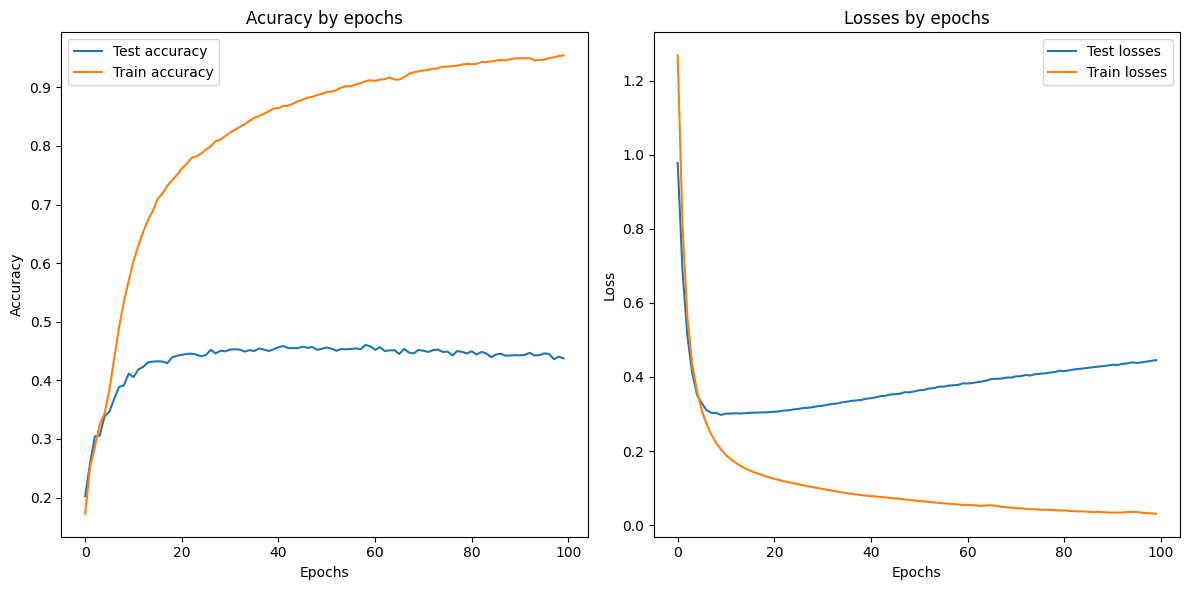

In [ ]:
# Створення нового зображення та осей з двома підграфіками
fig, axs = plt.subplots(1,2, figsize=(12, 6))

# Перший підграфік
axs[0].plot(model_3.test_accuracy, label='Test accuracy')
axs[0].plot(model_3.train_accuracy, label='Train accuracy')
axs[0].set_title('Acuracy by epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Другий підграфік
axs[1].plot(model_3.test_loss, label='Test losses')
axs[1].plot(model_3.train_loss, label='Train losses')
axs[1].set_title('Losses by epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Відображення зображення з усіма підграфіками
plt.tight_layout()
#plt.subplots_adjust(left=0.1, right=0.9)
plt.show()

Графіки підтверджують мою  думку, що мережа занадто перенавчена.

## Впилв функції активації

Треба перевірити вплив LeakyReLU, Parametric LeakyReLU, ELU на:  
  • час навчання мережi,  
  • якiсть роботи мережi (фiнальне значення accuracy) на перевiрочнiй
множинi,  
  • час надання прогнозу мережею.

In [ ]:
import time

network = [
    Dense(28 * 28, 100),
    LeakyReLU(),
    Dense(100, 10),
    Softmax()
]

# train
model = MLP(network, epochs=100, learning_rate=0.01, verbose = 0)

t0 = time.time()
model.train( X_train, y_train, X_test, y_test)
t1 = time.time()

t2 = time.time()
model.predict(X_test[0])
t3 = time.time()

print(f"LeakyReLU \nTime to train: {t1-t0}, Time to predict: {t3-t2}, Accuracy: {model.test_accuracy[-1]}")

network = [
    Dense(28 * 28, 100),
    ParametricLeakyReLU(),
    Dense(100, 10),
    Softmax()
]

# train
model = MLP(network, epochs=100, learning_rate=0.01, verbose = 0)

t0 = time.time()
model.train( X_train, y_train, X_test, y_test)
t1 = time.time()

t2 = time.time()
model.predict(X_test[0])
t3 = time.time()

print(f"ParametricLeakyReLU \nTime to train: {t1-t0}, Time to predict: {t3-t2}, Accuracy: {model.test_accuracy[-1]}")

network = [
    Dense(28 * 28, 100),
    ELU(),
    Dense(100, 10),
    Softmax()
]

# train
model = MLP(network, epochs=100, learning_rate=0.01, verbose = 0)

t0 = time.time()
model.train( X_train, y_train, X_test, y_test)
t1 = time.time()

t2 = time.time()
model.predict(X_test[0])
t3 = time.time()

print(f"ELU \nTime to train: {t1-t0}, Time to predict: {t3-t2}, Accuracy: {model.test_accuracy[-1]}")

LeakyReLU 
Time to train: 665.0375320911407, Time to predict: 0.00030493736267089844, Accuracy: 0.7315
ParametricLeakyReLU 
Time to train: 710.306839466095, Time to predict: 0.00029730796813964844, Accuracy: 0.7275
ELU 
Time to train: 659.2599678039551, Time to predict: 0.0003986358642578125, Accuracy: 0.7455


Можно побачити, що активатор впливає, але не супер критично наче.
Найбліьш помітна різниця в часі - ParametricLeakyReLU ворався за 12 хв, коли два іншиї активатори за 11, що може бути дуже суттєвим на великому масштабі. Далі поговоримо про точність, ParametricLeakyReLU знов виділяєтсья, але як найменш точна мережа, найкращий результат - ELU, в цієї ж мережи найбльіше часу уйшло на прогноз одного об'єкта.

## Приклади класифікації

### Функція для візуалізації

In [ ]:
def display_images(images, true_labels, predicted_labels, match=True, num_images=5):
    if match:
        indices = [i for i in range(len(true_labels)) if np.argmax(true_labels[i]) == predicted_labels[i]]
        title = "Matched Images:"
    else:
        indices = [i for i in range(len(true_labels)) if np.argmax(true_labels[i]) != predicted_labels[i]]
        title = "Mismatched Images:"

    for i in range(min(num_images, len(indices))):
        index = indices[i]
        plt.imshow(images[index], cmap='gray')
        plt.title(f"True Label: {np.argmax(true_labels[index])}, Predicted Label: {predicted_labels[index]}")
        plt.axis('off')
        plt.show()


In [ ]:
predicted_labels = []
for i in range(len(X_test)):
  predicted_labels.append(np.argmax(model.predict(X_test[i])))

### Неправильно

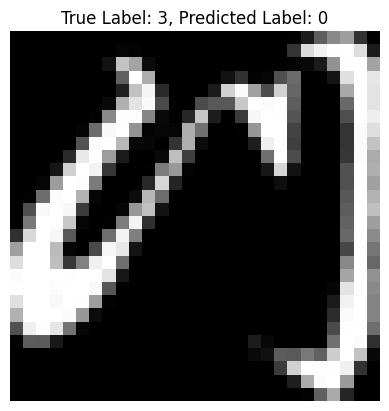

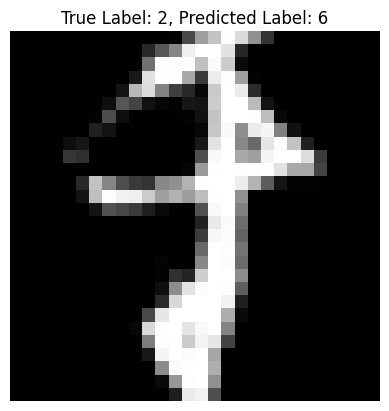

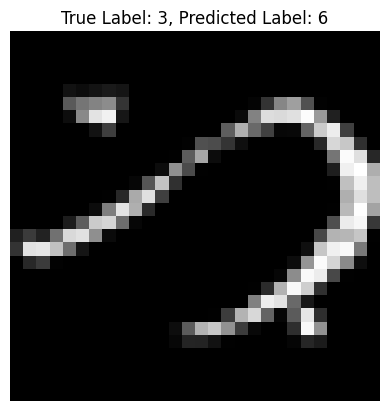

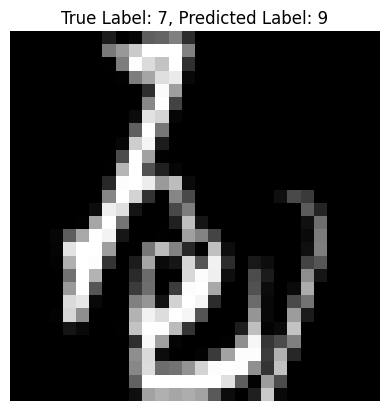

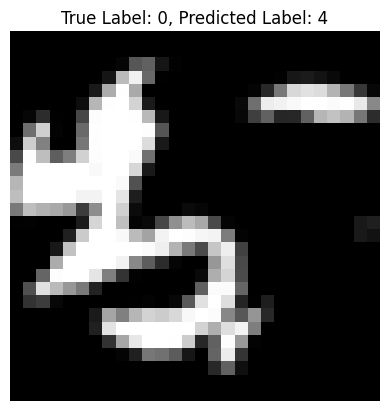

In [ ]:
 display_images(X_test.reshape(len(X_test),28,28), y_test, predicted_labels, False)

### Правильно

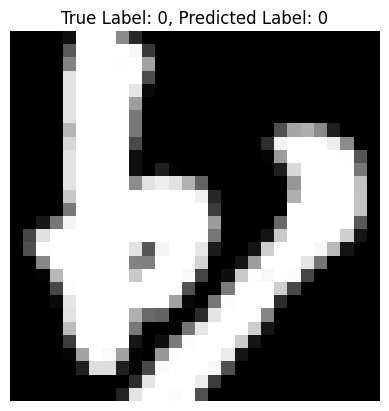

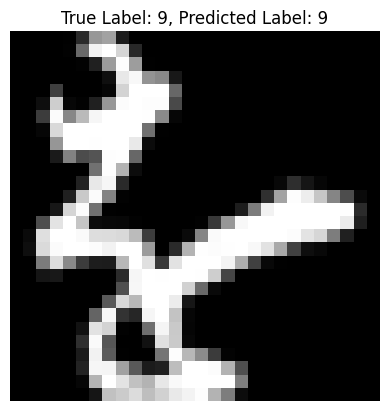

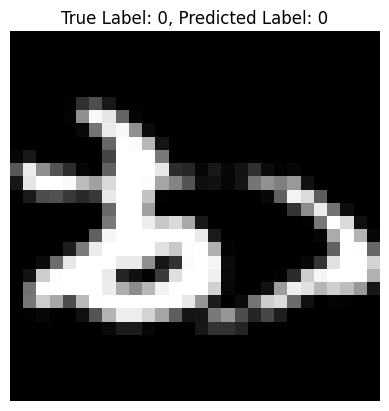

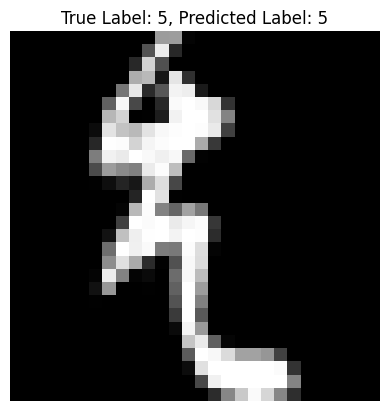

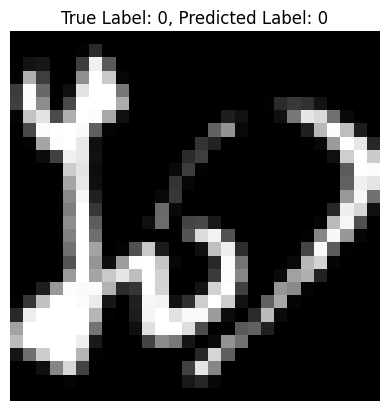

In [ ]:
 display_images(X_test.reshape(len(X_test),28,28), y_test, predicted_labels)

## Висновки

В цій роботі було побудовано власну енйронну мережу. Було створенно багато функцій активації (сігмоїд, ReLU, Leaky ReLU, гіперболічний тангенс і т.д.).
Був опрацьваний датасет Kuzushiji MNIST яйки представляє собою набір чорнобілих зображень рукописних ієрогліфів 16-18 ст. Японії розміром 28*28 пікселей. Датасет є склідніщим за традиційний MNIST через велику "дисперсію" того як ці ієрогліфи писали.Я використовува лише 10к зображень з 70к доступних і досяг ~75% accuracy, що досить непогано (порівнняо з +80% методами Tensor Flow бібліотеки Keras).